In [1]:
# Now, install the dependencies
!pip install datasets
!pip install torch


In [2]:
import os
from datasets import load_dataset
from transformers import AutoTokenizer
from huggingface_hub import notebook_login
from tqdm.auto import tqdm

# --- Step 1: Login to Hugging Face ---
# A login box will appear. Paste your Hugging Face access token here.
# Get a token at: https://huggingface.co/settings/tokens
print("Please log in to your Hugging Face account.")
notebook_login()


Please log in to your Hugging Face account.


In [3]:
import os
from datasets import load_dataset
from transformers import AutoTokenizer
from tqdm import tqdm

# --- Step 2: Configuration ---
PROJECT_PATH = ""
OUTPUT_DIR = os.path.join(PROJECT_PATH, "data")
os.makedirs(OUTPUT_DIR, exist_ok=True)

# ✅ Use small token target for testing
TARGET_TOKEN_COUNT = 50_000  # only ~50k tokens (tiny test)
MODEL_NAME = "meta-llama/Llama-3.2-3B"
LANGUAGES = ['en', 'hi']
CONFIG_DATE = '20231101'

print(f"Output directory for text files: {OUTPUT_DIR}")

# --- Step 3: Load the Tokenizer ---
print(f"Loading tokenizer for '{MODEL_NAME}'...")
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, use_auth_token=True)
print("Tokenizer loaded successfully.")

# --- Step 4: Process each language ---
for lang in LANGUAGES:
    print("\n" + "=" * 50)
    print(f"Processing language: {lang}")
    print("=" * 50)

    collected_documents = []
    current_token_count = 0

    dataset_config = f"{CONFIG_DATE}.{lang}"
    streaming_dataset = load_dataset(
        'wikimedia/wikipedia',
        dataset_config,
        split='train',
        streaming=True
    )

    pbar = tqdm(desc=f"Tokens for {lang}", total=TARGET_TOKEN_COUNT)
    for doc in streaming_dataset:
        if current_token_count >= TARGET_TOKEN_COUNT:
            break

        text = doc['text']
        if text:
            # ⚡ Limit text length for quick test
            text = text[:2000]
            num_tokens = len(tokenizer.encode(text))
            collected_documents.append(text)
            current_token_count += num_tokens
            pbar.update(num_tokens)
    pbar.close()

    # --- Step 5: Save to file ---
    output_filepath = os.path.join(OUTPUT_DIR, f"wikipedia_small_{lang}.txt")
    print(f"\nSaving {len(collected_documents)} docs ({current_token_count:,} tokens) to {output_filepath}...")

    with open(output_filepath, 'w', encoding='utf-8') as f:
        f.write("\n\n".join(collected_documents))

    print(f"✅ Successfully saved file for language '{lang}'.")

print("\n🎯 All languages processed successfully (test version)!")


Output directory for text files: data
Loading tokenizer for 'meta-llama/Llama-3.2-3B'...


/usr/local/lib/python3.12/dist-packages/transformers/models/auto/tokenization_auto.py:1010: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v5 of Transformers. Please use `token` instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Tokenizer loaded successfully.

Processing language: en


Resolving data files:   0%|          | 0/41 [00:00<?, ?it/s]

Tokens for en: 50229it [00:01, 32519.23it/s]                           



Saving 119 docs (50,229 tokens) to data/wikipedia_small_en.txt...
✅ Successfully saved file for language 'en'.

Processing language: hi


Tokens for hi: 50440it [00:01, 43682.58it/s]                           


Saving 55 docs (50,440 tokens) to data/wikipedia_small_hi.txt...
✅ Successfully saved file for language 'hi'.

🎯 All languages processed successfully (test version)!


In [4]:
import torch
import os
from transformers import AutoTokenizer
from tqdm.auto import tqdm

# --- Configuration ---
PROJECT_PATH = ""
DATA_DIR = os.path.join(PROJECT_PATH, "data")
MODEL_NAME = "meta-llama/Llama-3.2-3B"
LANGUAGES = ['en', 'hi']

print("🔹 Loading tokenizer...")
# ✅ Use `use_auth_token=True` for gated LLaMA models
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, use_auth_token=True)
print("✅ Tokenizer loaded successfully.")

# --- Tokenize each language safely ---
for lang in LANGUAGES:
    # ✅ Match small dataset filenames
    input_filepath = os.path.join(DATA_DIR, f"wikipedia_small_{lang}.txt")
    output_filepath = os.path.join(DATA_DIR, f"id.{lang}.train.small.llama.pt")

    print("\n" + "=" * 60)
    print(f"Processing language: {lang}")
    print(f"Reading from: {input_filepath}")
    print(f"Saving to: {output_filepath}")
    print("=" * 60)

    if not os.path.exists(input_filepath):
        print(f"❌ ERROR: Input file not found at {input_filepath}")
        continue

    token_ids = []

    # --- Stream through the file line by line ---
    with open(input_filepath, 'r', encoding='utf-8') as f:
        for line in tqdm(f, desc=f"Tokenizing {lang}"):
            line = line.strip()
            if not line:
                continue

            # Encode the line into token IDs
            ids = tokenizer.encode(line, add_special_tokens=False)
            token_ids.extend(ids)

            # ✅ Flush every 50k tokens (enough for test)
            if len(token_ids) > 50_000:
                torch.save(torch.LongTensor(token_ids), output_filepath)
                token_ids = []

    # --- Save remaining tokens ---
    if token_ids:
        torch.save(torch.LongTensor(token_ids), output_filepath)

    print(f"✅ Saved token tensor for '{lang}' → {output_filepath}")

print("\n🎯 All tokenization steps complete (test mode)!")


🔹 Loading tokenizer...
✅ Tokenizer loaded successfully.

Processing language: en
Reading from: data/wikipedia_small_en.txt
Saving to: data/id.en.train.small.llama.pt


Tokenizing en: 0it [00:00, ?it/s]

✅ Saved token tensor for 'en' → data/id.en.train.small.llama.pt

Processing language: hi
Reading from: data/wikipedia_small_hi.txt
Saving to: data/id.hi.train.small.llama.pt


Tokenizing hi: 0it [00:00, ?it/s]

✅ Saved token tensor for 'hi' → data/id.hi.train.small.llama.pt

🎯 All tokenization steps complete (test mode)!


**activation.py**

In [17]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer
from tqdm.auto import tqdm

MODEL_NAME = "meta-llama/Llama-3.2-3B"
LANGUAGES = ['en', 'hi']
BATCH_SIZE = 2
MAX_LENGTH = 1024

# Load tokenizer and model
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, use_auth_token=True)
model = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME,
    device_map="auto",
    torch_dtype=torch.float16
)
model.eval()

num_layers = model.config.num_hidden_layers
intermediate_size = model.config.intermediate_size  # 8192

# Prepare counter
over_zero = torch.zeros(num_layers, intermediate_size, dtype=torch.int32).to('cuda')

# Hook function for full MLP output
def mlp_hook(layer_idx):
    def hook(module, input, output):
        # output shape: [batch, seq_len, intermediate_size]
        activation = output.float()
        over_zero[layer_idx, :activation.size(-1)] += (activation > 0).sum(dim=(0,1))
    return hook

# Register hook for each layer's MLP
for i, layer in enumerate(model.model.layers):
    layer.mlp.register_forward_hook(mlp_hook(i))

# Example: processing dummy input
for lang in LANGUAGES:
    # Load token IDs (already prepared)
    tensor_path = f"data/id.{lang}.train.small.llama.pt"
    ids = torch.load(tensor_path).to('cuda')
    total_tokens = ids.size(0)

    for start in tqdm(range(0, total_tokens, BATCH_SIZE * MAX_LENGTH), desc=f"Processing {lang}"):
        batch_ids = []
        for b in range(BATCH_SIZE):
            s = start + b * MAX_LENGTH
            if s >= total_tokens:
                break
            e = min(s + MAX_LENGTH, total_tokens)
            chunk = ids[s:e]
            if chunk.size(0) < MAX_LENGTH:
                chunk = torch.cat([chunk, torch.zeros(MAX_LENGTH - chunk.size(0), dtype=chunk.dtype, device='cuda')])
            batch_ids.append(chunk)
        if not batch_ids:
            continue

        batch_ids = torch.stack(batch_ids, dim=0)
        attention_mask = (batch_ids != 0).long()
        with torch.no_grad():
            _ = model(input_ids=batch_ids, attention_mask=attention_mask)

    # Save activations
    output_path = f"data/activation.{lang}.train.small.llama3b.pt"
    torch.save({'over_zero': over_zero.cpu()}, output_path)
    print(f"✅ Saved activations for {lang} → {output_path}")


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Processing en:   0%|          | 0/25 [00:00<?, ?it/s]

✅ Saved activations for en → data/activation.en.train.small.llama3b.pt


Processing hi:   0%|          | 0/25 [00:00<?, ?it/s]

✅ Saved activations for hi → data/activation.hi.train.small.llama3b.pt


Keys in file: dict_keys(['over_zero'])
Shape of over_zero: torch.Size([28, 8192])
Min activation count: 0
Max activation count: 49573
First 10 neurons of first layer: tensor([21745, 23120, 15606, 24962, 21901, 28435, 22055, 24787, 16062, 28269],
       dtype=torch.int32)
Total positive activations: 2157924767


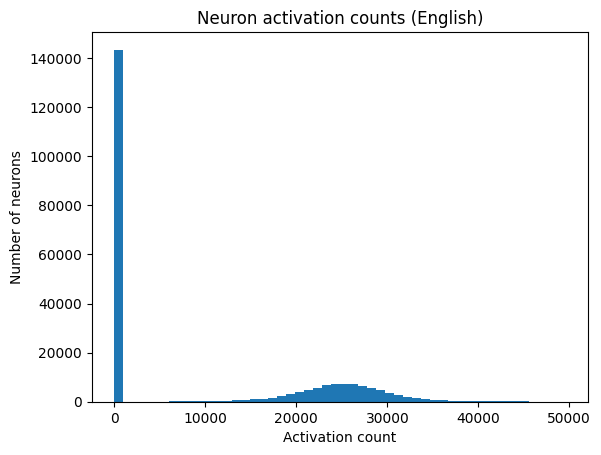

In [18]:
import torch
import matplotlib.pyplot as plt

# -------------------------------
# Step 1: Load the activation file
# -------------------------------
activation_path = "data/activation.en.train.small.llama3b.pt"
data = torch.load(activation_path)

print("Keys in file:", data.keys())

# -------------------------------
# Step 2: Inspect shape
# -------------------------------
over_zero = data['over_zero']
print("Shape of over_zero:", over_zero.shape)

# -------------------------------
# Step 3: Inspect values
# -------------------------------
print("Min activation count:", over_zero.min().item())
print("Max activation count:", over_zero.max().item())
print("First 10 neurons of first layer:", over_zero[0, :10])

# -------------------------------
# Step 4: Total activations
# -------------------------------
total_activations = over_zero.sum().item()
print("Total positive activations:", total_activations)

# -------------------------------
# Step 5: Optional - visualize distribution
# -------------------------------
plt.hist(over_zero.flatten().cpu().numpy(), bins=50)
plt.title("Neuron activation counts (English)")
plt.xlabel("Activation count")
plt.ylabel("Number of neurons")
plt.show()


Keys in file: dict_keys(['over_zero'])
Shape of over_zero: torch.Size([28, 8192])
Min activation count: 0
Max activation count: 99563
First 10 neurons of first layer: tensor([47778, 46565, 34556, 52237, 34115, 57390, 59646, 52426, 31019, 48751],
       dtype=torch.int32)
Total positive activations: 4314963670


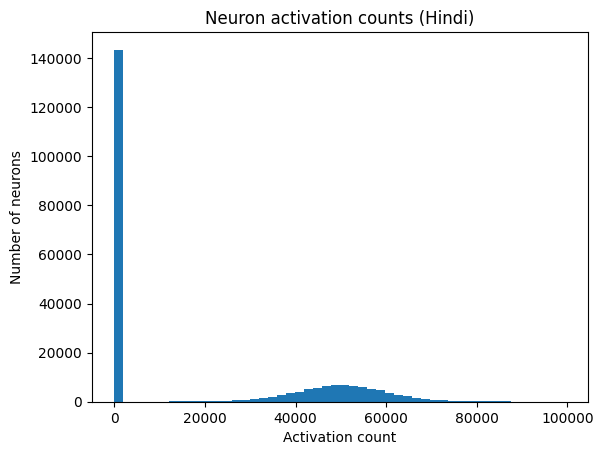

In [19]:


# -------------------------------
# Step 1: Load the activation file
# -------------------------------
activation_path = "data/activation.hi.train.small.llama3b.pt"
data = torch.load(activation_path)

print("Keys in file:", data.keys())

# -------------------------------
# Step 2: Inspect shape
# -------------------------------
over_zero = data['over_zero']
print("Shape of over_zero:", over_zero.shape)

# -------------------------------
# Step 3: Inspect values
# -------------------------------
print("Min activation count:", over_zero.min().item())
print("Max activation count:", over_zero.max().item())
print("First 10 neurons of first layer:", over_zero[0, :10])

# -------------------------------
# Step 4: Total activations
# -------------------------------
total_activations = over_zero.sum().item()
print("Total positive activations:", total_activations)

# -------------------------------
# Step 5: Optional - visualize distribution
# -------------------------------
plt.hist(over_zero.flatten().cpu().numpy(), bins=50)
plt.title("Neuron activation counts (Hindi)")
plt.xlabel("Activation count")
plt.ylabel("Number of neurons")
plt.show()


In [20]:
import torch
import pandas as pd
import numpy as np

# -------------------------------
# Step 0: Load the activation file
# -------------------------------
file_path = 'data/activation.en.train.small.llama3b.pt'  # change 'en' to your language
data = torch.load(file_path)

# over_zero shape: [num_layers, intermediate_size]
over_zero = data['over_zero'].cpu()

# -------------------------------
# Step 1: Convert to NumPy for easier printing
# -------------------------------
matrix = over_zero.numpy()

# Option 1: Print full matrix (all neurons for all layers)
np.set_printoptions(threshold=np.inf)
print("Activation counts per neuron per layer:\n", matrix)

# Option 2: Save to CSV for inspection
df = pd.DataFrame(matrix)
csv_path = file_path.replace(".pt", ".csv")
df.to_csv(csv_path, index=False)
print(f"✅ Saved activations to CSV: {csv_path}")

# -------------------------------
# Step 2: Layer-wise printing
# -------------------------------
num_layers = over_zero.size(0)
for layer_idx in range(num_layers):
    print(f"Layer {layer_idx}: {over_zero[layer_idx]}")


Streaming output truncated to the last 5000 lines.
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0

In [11]:
import torch
import pandas as pd
import numpy as np

# --- Load the activation file ---
file_path = 'data/activation.en.train.small.llama3b.pt'
data = torch.load(file_path)

over_zero = data['over_zero'].cpu()  # 28 x 8192

# --- Convert to NumPy for easier printing ---
matrix = over_zero.numpy()

# Option 1: Print the full matrix (will flood the console)
np.set_printoptions(threshold=np.inf)  # show all elements
print(matrix)

# Option 2: Save to CSV (recommended for inspection)
df = pd.DataFrame(matrix)
csv_path = file_path.replace(".pt", ".csv")
df.to_csv(csv_path, index=False)
print(f"✅ over_zero tensor saved to CSV: {csv_path}")


[[20905 23367 15461 24755 20663 27565 21097 25467 18857 25510 24040 24285
  20994 25042 14833 17016 22709 25049 43759 23431 18300 31555 23557 28199
  34009 16711 25621 32878 23947 23131 25876 23546 23713 26583 45127 21105
  24717 25514 20977 20966 11123 23250 18558 20705 30098 23804 17568 22278
  27602 29059 22718 25311 23967 26561 27794 22137 21506 27941 26179 21432
  29142 22862 28238 31772  8172 30376 24727 24593 25160 28827 20253 23236
  24395 23672 19281 27138 18875 26806 26478 18244 19751 28569 22281 26130
  32674 31061 18362 19360 25733 29574 19519 20382 27152 28882 22321 25615
  26080 26212 22257 16497 24446 25513 20115  1979 28998 30402 27720 30269
  22785 21665 21675 28895 21923 26744 27136 27772 19078 26413 25449 24445
  20850 18101 37020 25665 11844 25283 26739 23961 30430 26077 31564 19694
  28728 29684 23027 19035 30930 28706 23576 23111 27684 24506 25703 28055
  25722 25927 25601 20290 26456 19368 20751 25421 24429 23765 26913 26737
  26810 25050 22110 21370 20980 22688 

In [12]:
file_path = 'data/activation.hi.train.small.llama3b.pt'
data = torch.load(file_path)

over_zero = data['over_zero'].cpu()  # 28 x 8192

# --- Convert to NumPy for easier printing ---
matrix = over_zero.numpy()

# Option 1: Print the full matrix (will flood the console)
np.set_printoptions(threshold=np.inf)  # show all elements
print(matrix)

# Option 2: Save to CSV (recommended for inspection)
df = pd.DataFrame(matrix)
csv_path = file_path.replace(".pt", ".csv")
df.to_csv(csv_path, index=False)
print(f"✅ over_zero tensor saved to CSV: {csv_path}")

[[47808 47178 33929 52140 32130 56871 57913 52086 36487 41966 55345 54398
  36030 52087 31762 38372 43287 51916 90447 51907 31832 54871 42699 62363
  72986 31948 46524 60910 43114 51228 51208 44645 51105 55497 91778 40408
  43416 51437 50544 48378 15961 41195 38011 46406 65515 42908 38848 42022
  53328 59963 50778 47530 43181 55898 55724 41994 38773 49288 51487 46743
  62472 53595 55900 67064 19292 66915 44829 46273 50488 54317 57267 54494
  44751 54581 35504 50348 42923 56752 50383 27078 46570 59150 48468 54704
  58233 59236 34449 34777 55046 53486 34560 39358 49777 48594 45288 43352
  56309 56607 44297 41226 49292 53607 42265 22556 53409 53102 60192 62058
  43870 33175 42766 59202 39924 52425 52815 58992 41347 57979 47667 42024
  43971 31004 81956 52172 17521 53653 51120 40974 65528 50429 68187 41618
  58464 63934 46666 37844 51208 63157 44383 42061 50598 53961 50131 56952
  52545 60155 62130 41107 63083 41136 41237 42891 52670 49178 61319 50857
  56644 54813 42935 46590 42461 52684 

Checking for es and saving activations in csv

In [31]:
import torch
import numpy as np
import pandas as pd
import os

# --- Load activation data ---
file_path = '/content/data/activation.es.train.llama-7b'
data = torch.load(file_path, map_location='cpu')  # ensure it's on CPU

over_zero = data['over_zero']  # shape: [layers, neurons]

# --- Convert to NumPy for easier inspection ---
matrix = over_zero.cpu().numpy()  # ensure CPU for NumPy

# --- Option 1: Print the full matrix ---
# WARNING: May flood the console for large matrices
print_matrix = False  # set True if you really want to print everything
if print_matrix:
    np.set_printoptions(threshold=np.inf)  # show all elements
    print(matrix)

# --- Option 2: Save to CSV (recommended) ---
csv_dir = '/content/data/csv_exports'
os.makedirs(csv_dir, exist_ok=True)

# handle filenames without '.pt'
base_name = os.path.basename(file_path)
if base_name.endswith('.pt'):
    csv_name = base_name.replace('.pt', '.csv')
else:
    csv_name = base_name + '.csv'

csv_path = os.path.join(csv_dir, csv_name)
df = pd.DataFrame(matrix)
df.to_csv(csv_path, index=False)
print(f"✅ over_zero tensor saved to CSV: {csv_path}")


✅ over_zero tensor saved to CSV: /content/data/csv_exports/activation.es.train.llama-7b.csv


**identify.py**

In [13]:
import torch
import os

# --- Configuration ---
languages = ['en', 'hi']  # your hi-en dataset
activation_dir = 'data'
output_dir = 'activation_mask'
os.makedirs(output_dir, exist_ok=True)

top_rate = 0.01           # fraction of neurons to select (entropy-based)
filter_rate = 0.95        # top 5% neurons threshold
activation_bar_ratio = 0.95  # top 5% activation threshold

# --- Load activation data ---
over_zero = []
for lang in languages:
    file_path = os.path.join(activation_dir, f'activation.{lang}.train.small.llama3b.pt')
    data = torch.load(file_path)
    over_zero.append(data['over_zero'])

# shape: [layers, neurons, languages]
over_zero = torch.stack(over_zero, dim=-1)
num_layers, intermediate_size, lang_num = over_zero.size()
print(f"{lang_num} languages, {num_layers} layers, {intermediate_size} neurons per layer")

# --- Compute activation probabilities across languages ---
activation_probs = over_zero / over_zero.sum(dim=-1, keepdim=True)
activation_probs[torch.isnan(activation_probs)] = 0

# --- Compute entropy across languages ---
log_probs = torch.where(activation_probs > 0, activation_probs.log(), 0)
entropy = -torch.sum(activation_probs * log_probs, dim=-1)  # shape: [layers, neurons]

# --- Filter neurons with very low activation ---
flattened_probs = activation_probs.flatten()
top_prob_value = flattened_probs.kthvalue(round(len(flattened_probs) * filter_rate)).values.item()
active_neurons = (activation_probs > top_prob_value).sum(dim=-1)
entropy[active_neurons == 0] = torch.inf  # ignore inactive neurons

# --- Select top neurons by smallest entropy (language-specific) ---
flattened_entropy = entropy.flatten()
top_entropy_value = round(len(flattened_entropy) * top_rate)
_, index = flattened_entropy.topk(top_entropy_value, largest=False)  # smallest entropy = language-specific

row_index = index // entropy.size(1)
col_index = index % entropy.size(1)

# --- Build and save per-language masks separately ---
for lang_id, lang_name in enumerate(languages):
    # select probabilities for this language
    lang_probs = activation_probs[:, :, lang_id]

    # filter selected neurons by top entropy indices
    selected_mask = torch.zeros_like(lang_probs, dtype=torch.bool)
    selected_mask[row_index, col_index] = True

    # further filter by activation intensity
    activation_bar = flattened_probs.kthvalue(round(len(flattened_probs) * activation_bar_ratio)).values.item()
    selected_mask &= (lang_probs > activation_bar)

    # build layer-wise neuron indices
    layer_indices = []
    for layer in range(num_layers):
        neurons = torch.where(selected_mask[layer])[0]
        layer_indices.append(neurons)

    # save to separate file
    output_file = os.path.join(output_dir, f"llama3b_{lang_name}_mask.pt")
    torch.save(layer_indices, output_file)
    print(f"✅ Activation mask for {lang_name} saved to: {output_file}")


2 languages, 28 layers, 8192 neurons per layer
✅ Activation mask for en saved to: activation_mask/llama3b_en_mask.pt
✅ Activation mask for hi saved to: activation_mask/llama3b_hi_mask.pt


In [14]:
import torch
import os

# --- Configuration ---
output_dir = 'activation_mask'
languages = ['en', 'hi']

for lang in languages:
    file_path = os.path.join(output_dir, f'llama3b_{lang}_mask.pt')

    # Load the saved mask
    layer_masks = torch.load(file_path)

    print(f"\n--- Activation mask for {lang.upper()} ---")
    print("layer-wise neuron indices = [")

    for i, neuron_tensor in enumerate(layer_masks):
        print(f"    layer {i}: tensor({neuron_tensor.tolist()})")

    print("]\n")



--- Activation mask for EN ---
layer-wise neuron indices = [
    layer 0: tensor([])
    layer 1: tensor([])
    layer 2: tensor([])
    layer 3: tensor([])
    layer 4: tensor([])
    layer 5: tensor([])
    layer 6: tensor([])
    layer 7: tensor([])
    layer 8: tensor([])
    layer 9: tensor([])
    layer 10: tensor([])
    layer 11: tensor([])
    layer 12: tensor([])
    layer 13: tensor([])
    layer 14: tensor([])
    layer 15: tensor([])
    layer 16: tensor([])
    layer 17: tensor([])
    layer 18: tensor([])
    layer 19: tensor([])
    layer 20: tensor([])
    layer 21: tensor([])
    layer 22: tensor([])
    layer 23: tensor([])
    layer 24: tensor([])
    layer 25: tensor([])
    layer 26: tensor([])
    layer 27: tensor([])
]


--- Activation mask for HI ---
layer-wise neuron indices = [
    layer 0: tensor([6, 70, 103, 418, 423, 463, 769, 940, 1215, 1275, 1283, 1286, 1322, 1372, 1380, 1391, 1480, 1534, 1693, 1731, 1830, 1895, 1935, 2135, 2142, 2184, 2195, 2222, 2250,